### Advanced Machine Learning

# Home Exercise #1

Assignment Due: 21/03/21 23:59

Jonathan Schler


In [1]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.impute import KNNImputer,SimpleImputer
import seaborn as sns

%matplotlib inline

# add more imports as needed

## Task 1 Regression on Ames Housing Dataset (60 Points)

You can load the Ames housing dataset from <br>
http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls <br>
You can find a description of the variables here: <br>
http://jse.amstat.org/v19n3/decock/DataDocumentation.txt <br>
Take note that for categorical variables, NA here does not mean a missing value, but should be treated as a separate category.

In [3]:
# "Misc Feature", "Fence", "Pool QC", "Alley" - because only ~200 rows contains data - less than 10%
COLUMNS_TO_DROP = [
    # "SalePrice", 
    "PID", 
    "Order", 
    "Misc Feature", 
    "Fence", 
    "Pool QC", 
    "Alley", 
    "Fireplace Qu"
] 

def read_data():
    return pd.read_excel("AmesHousing.xls")

def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

def read_and_drop_nan_col():
    df = read_data()
    return drop_columns(df,COLUMNS_TO_DROP)

def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

def get_categorical_features(df):
    return df.select_dtypes(include=['object'])

In [15]:
df = read_and_drop_nan_col()
continuous_features = get_continuous_features(drop_columns(df, ['SalePrice']))
categorical_features = get_categorical_features(df)

### Question 1.1
Visualize the univariate distribution of each continuous attribute, and the distribution of the target. Make sure you skip the string\categorial columns (you can do it using call to `select_dtypes(exclude=['object'])`).

Do you notice anything? Is there something that might require special treatment?

In [16]:
# todo: we need to know how to take the whole data
y = df.SalePrice

# TODO: should we drop SalePrice here?
y_limit = y.max()
y.max()

755000

In [17]:
features_description = {
    "MS SubClass": "type of dwelling involved in the sale",
    "Lot Frontage": "Linear feet of street connected to property",
    "Lot Area": "Lot size in square feet",
    "Overall Qual": "Rates the overall material and finish of the house",
    "Overall Cond": "Rates the overall condition of the house",
    "Year Built": "Original construction date",
    "Year Remod/Add": "Remodel date (same as construction date if no remodeling or additions)",
    "Mas Vnr Area": "Masonry veneer area in square feet",
    "BsmtFin SF 1": "Type 1 finished square feet",
    "BsmtFin SF 2": "Type 2 finished square feet",
    "Bsmt Unf SF": "Unfinished square feet of basement area",
    "Total Bsmt SF": "Total square feet of basement area",
    "1st Flr SF": "First Floor square feet",
    "2nd Flr SF": "Second floor square feet",
    "Low Qual Fin SF": "Low quality finished square feet (all floors)",
    "Gr Liv Area": "Above grade (ground) living area square feet",
    "Bsmt Full Bath": "Basement full bathrooms",
    "Bsmt Half Bath": "Basement half bathrooms",
    "Bsmt Full Bath": "Basement full bathrooms",
    "Full Bath": "Full bathrooms above grade",
    "Half Bath": "Half baths above grade",
    "Fireplaces": "Number of fireplaces",
    "Misc Val": "Value of miscellaneous feature",
    "3Ssn Porch": "Three season porch area in square feet"
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

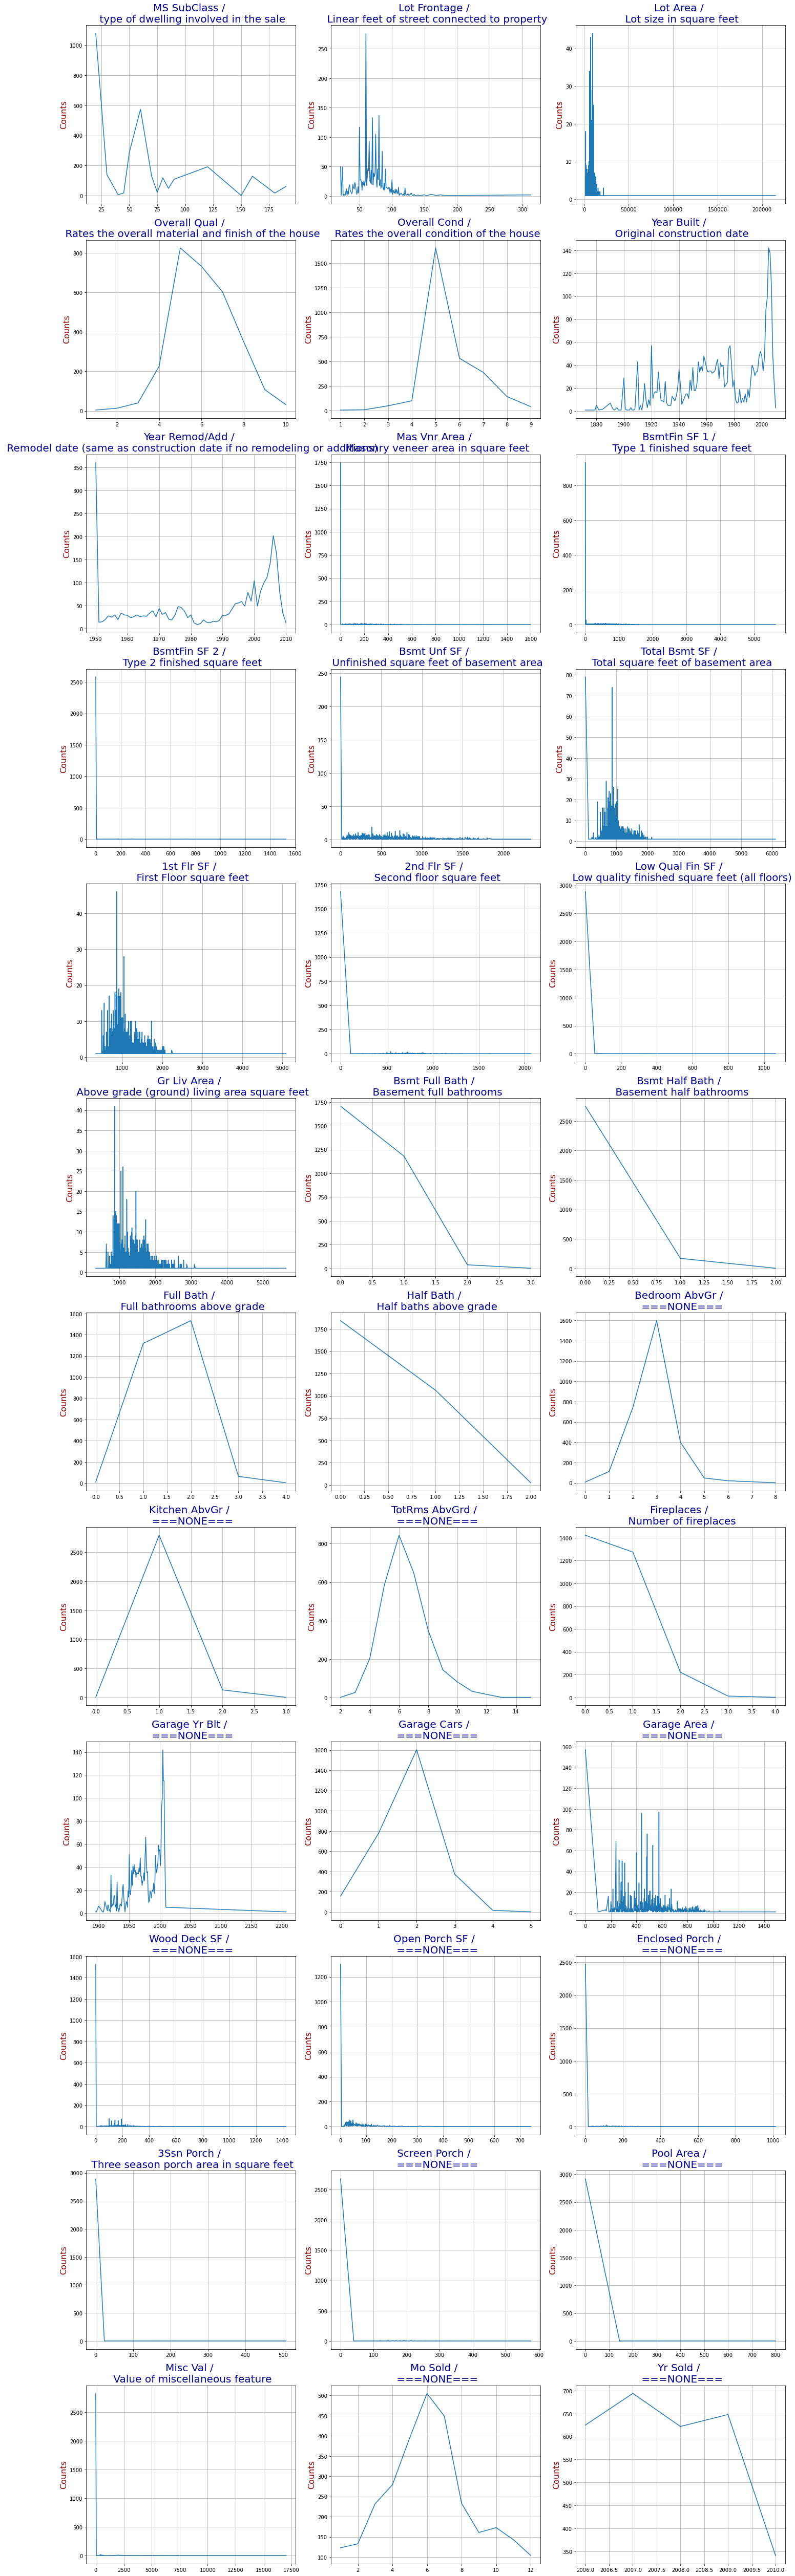

In [19]:
fig, axes = plt.subplots(12, 3, figsize=(20, 70))

for i, ax in enumerate(axes.ravel()):
    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = continuous_features[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Counts", fontdict=labels_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()


### The plot allows to define the following:
most of the feautures must be scaled and normalized:
<ul>
<li>lot frontage, lot area, total basement SF, garage year build and many other features aren't distributed around the median (there is a skew of the data)</li>
<li>second floor, low quality SF, area and other features have a number of extreme values, and should be presented using log axis</li>
<li>features have different scale, distribution and standard deviation</li></ul>

### Question 1.2
Visualize the dependency of the target on each continuous feature (2d scatter plot).

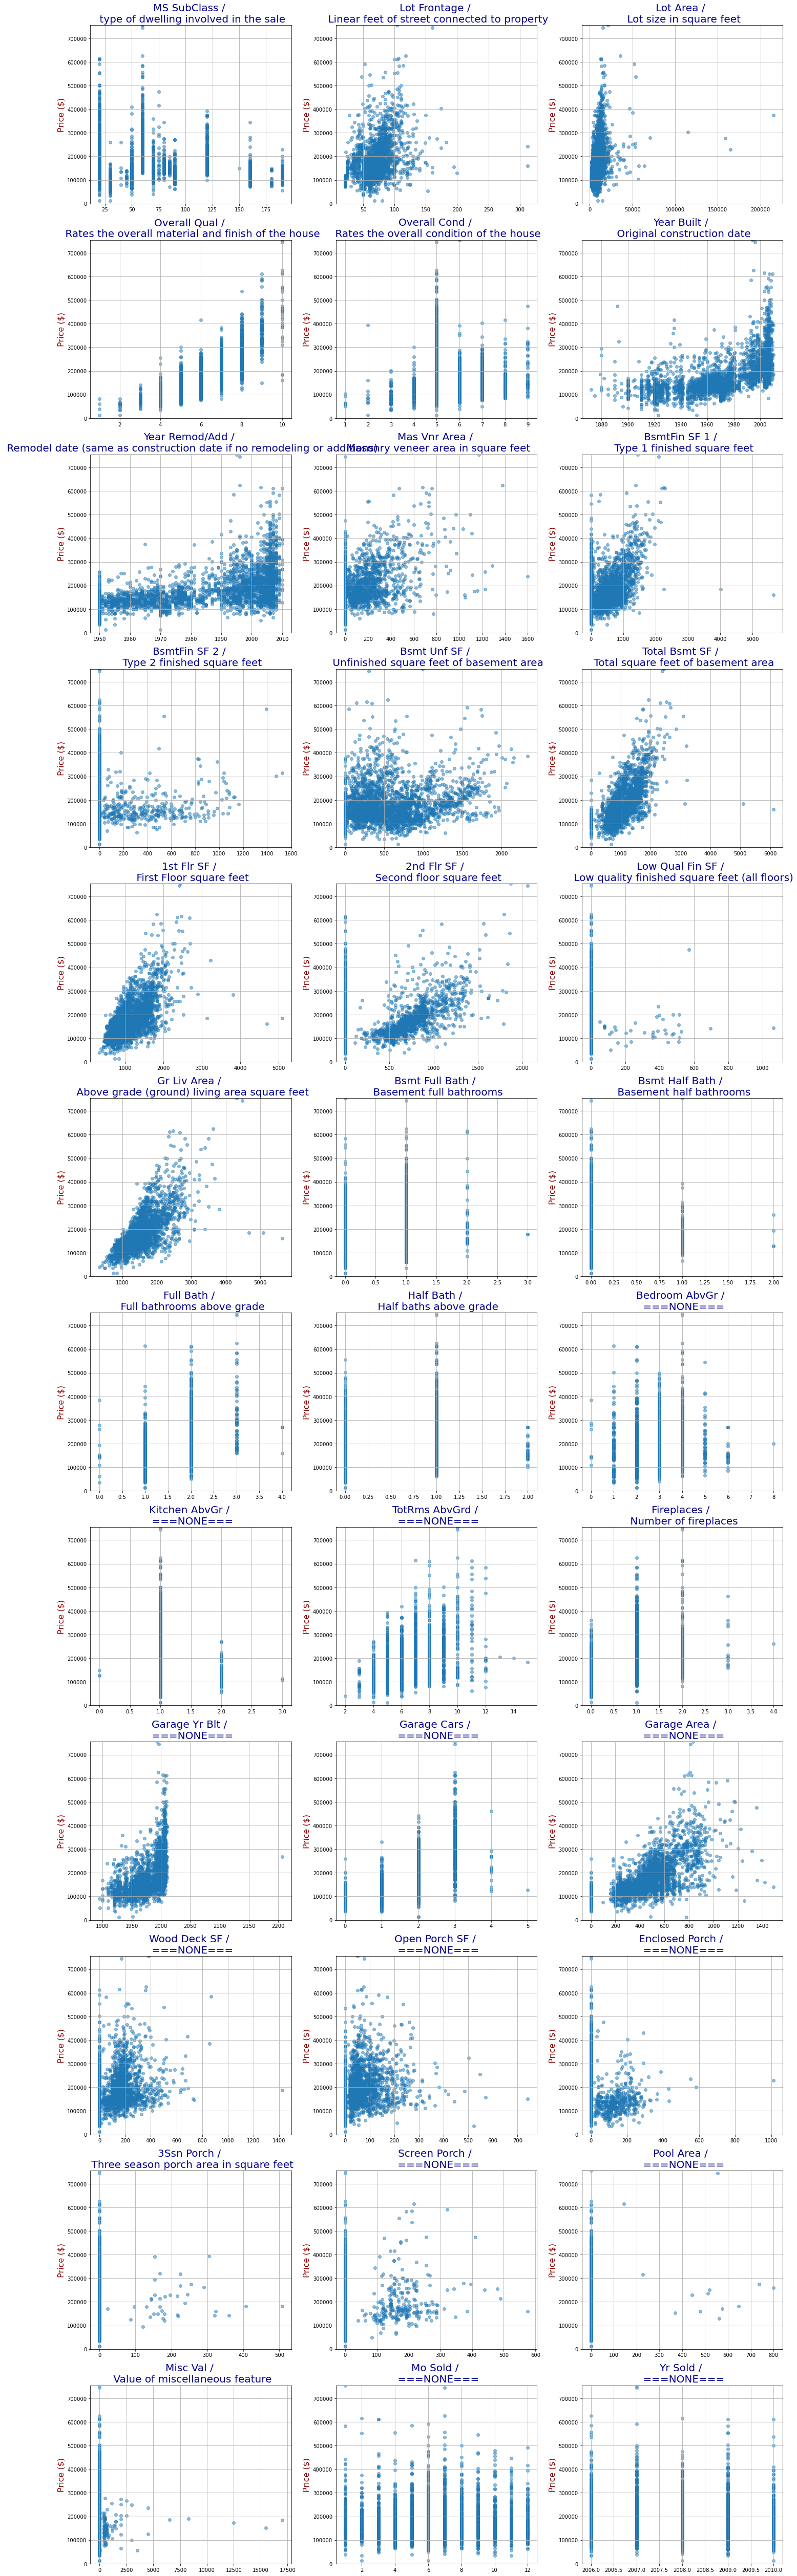

In [21]:
fig, axes = plt.subplots(12, 3, figsize=(20, 70))
y = df.SalePrice

for i, ax in enumerate(axes.ravel()):
    X_col = continuous_features.iloc[:, i]
    ax.set_ylim(0, y_limit)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(X_col, y, alpha=.5)

    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

### Question 1.3
Split data in training and test set. Do not use the test-set unless for a final evaluation in 1.6.
For each categorical variable, cross-validate a Linear Regression model using just this variable
(one-hot-encoded). Visualize the relationship of the categorical variables that provide the best
R^2 value with the target.

<AxesSubplot:>

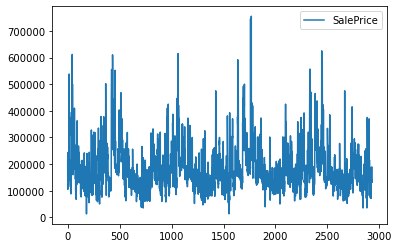

In [11]:
#plot the price to see how it's spreaded across the indexes
df.plot.line(y='SalePrice')


<AxesSubplot:title={'center':'SalePrice'}, xlabel='Sale Condition'>

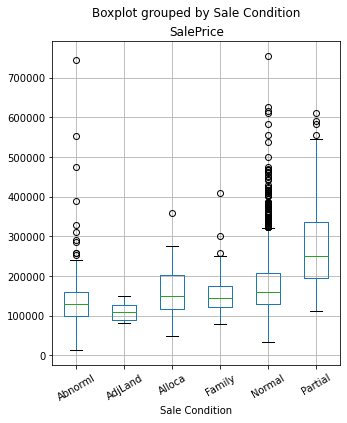

In [12]:
# categorical_features.plot(kind='box')
#TBD add plot in a loop (doesn't work as expected)
df.boxplot('SalePrice','Sale Condition',rot = 30,figsize=(5,6))

In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

categorical_features = dropped_df.select_dtypes(include=['object'])
y = df['SalePrice']
categorical_features.fillna("missing",inplace=True)
X_train, X_test, y_train, y_test = train_test_split(categorical_features, y, random_state=0)
encoder  = OneHotEncoder()
r2_scores = np.empty((0,2))
for column in X_train:
        two_d = X_train[column].values.reshape(-1,1)        
        array_hot_encoded = encoder.fit_transform(two_d).toarray()
        data_hot_encoded_df = pd.DataFrame(array_hot_encoded, index=X_train.index)
        data_hot_encoded_df.columns = encoder.get_feature_names() 
        score = np.mean(cross_val_score(LinearRegression(), data_hot_encoded_df, y_train, cv=10))
        r2_scores = np.concatenate((r2_scores, [[column, score]]))
        
r2_scores = r2_scores[r2_scores[:,1].argsort()[::-1]]
r2_scores

/Users/alexanderkruglyak/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


array([['Exter Qual', '0.5182776658797761'],
       ['Garage Finish', '0.3014808551677171'],
       ['Foundation', '0.27037879883816984'],
       ['Garage Type', '0.23341578433978444'],
       ['BsmtFin Type 1', '0.21954322887609062'],
       ['Heating QC', '0.21450421685378168'],
       ['Bsmt Exposure', '0.17960466817363713'],
       ['Sale Condition', '0.12132204254052344'],
       ['Lot Shape', '0.08674653684641177'],
       ['Garage Cond', '0.07881493948577237'],
       ['Garage Qual', '0.07513383077624425'],
       ['Paved Drive', '0.07369133930763463'],
       ['Central Air', '0.06742013758275209'],
       ['House Style', '0.06403506836921888'],
       ['Roof Style', '0.06134937560588544'],
       ['Land Contour', '0.04288435077506949'],
       ['Bsmt Cond', '0.04261950240592749'],
       ['Bldg Type', '0.03139250032899874'],
       ['Condition 1', '0.02691645389932066'],
       ['BsmtFin Type 2', '0.022085334320135475'],
       ['Exter Cond', '0.020013227268517442'],
       ['L

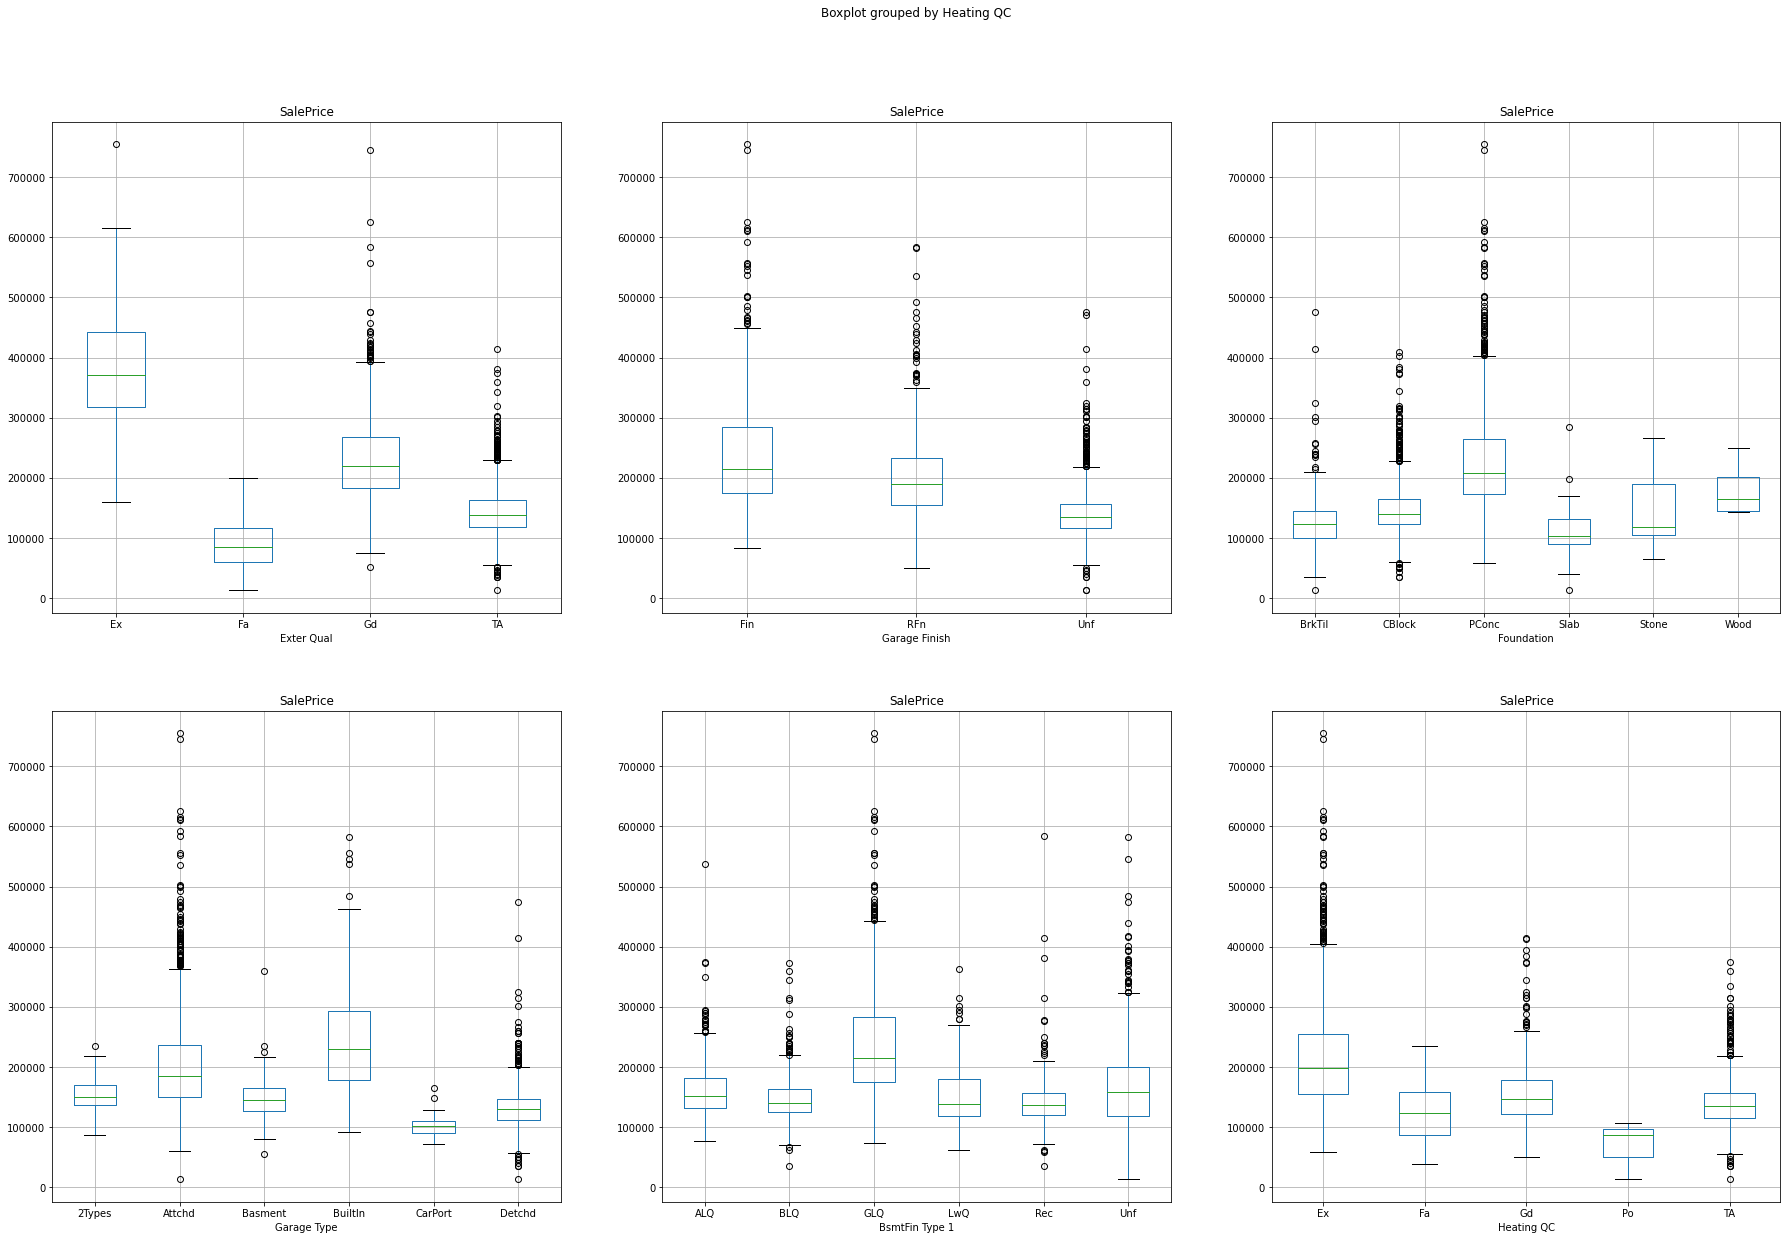

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(30,20))
for i, ax in enumerate(axes.ravel()):
    df.boxplot('SalePrice',r2_scores[i,0], ax=ax)

### Question 1.4
Use ColumnTransformer and pipeline to encode categorical variables. Evaluate Linear
Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default
parameters. Does scaling the data (within the pipeline) with StandardScaler help?

In [41]:
def impute_numeric(df):
    return pd.DataFrame(KNNImputer().fit_transform(df),columns = df.columns,index=df.index)

In [42]:
def impute_categorical(df):
    return df.fillna("missing")

In [43]:
def scale_numeric(df):
    return StandardScaler().fit_transform(df)

## Preprocess data
### Impute and OneHotEncoding

In [44]:
#numeric = scale_numeric(dropped_df.select_dtypes(exclude=['object'])) #TBD replace separated calls with pipe
#numeric = impute_numeric(dropped_df.select_dtypes(exclude=['object']))
initial_df = read_and_drop_nan_col()
numeric = initial_df.select_dtypes(exclude=['object'])
categorical = impute_categorical(initial_df.select_dtypes(include=['object']))
encoder = OneHotEncoder(sparse=False)
categorical_onehot = pd.DataFrame(encoder.fit_transform(categorical))
categorical_onehot.columns = encoder.get_feature_names(categorical.columns)
common_df = categorical_onehot.join(numeric)
common_df # entire data set with encoded values
common_df

,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,210,62,0,0,0,0,0,5,2010,215000
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,140,0,0,0,120,0,0,6,2010,105000
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,393,36,0,0,0,0,12500,6,2010,172000
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,4,2010,244000
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,212,34,0,0,0,0,0,3,2010,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,120,0,0,0,0,0,0,3,2006,142500
2926,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,164,0,0,0,0,0,0,6,2006,131000
2927,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,80,32,0,0,0,0,700,7,2006,132000
2928,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,240,38,0,0,0,0,0,4,2006,170000


### Split imputed and encoded data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(common_df, y, random_state=0)

### Cross-validation with the default parameters

In [46]:
scores = {}

df_clean = read_and_drop_nan_col()
df_clean
df_clean= df_clean.dropna()
y = df_clean['SalePrice']
df_clean = drop_columns(df_clean,['SalePrice'])

# df_clean.columns
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, random_state=0)
categorical = X_train.dtypes == object

preprocess_scaled = make_column_transformer(
    (StandardScaler(), ~categorical),
    (OneHotEncoder(), categorical))

preprocess = make_column_transformer(
    (OneHotEncoder(), categorical))

scaled_pipe = make_pipeline(preprocess_scaled,LinearRegression())
mean= np.mean(cross_val_score(scaled_pipe, X_train, y_train))
mean
# #disregard warning
# rergressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()] 
# for regr in rergressors:
#     scaled_pipe = make_pipeline(preprocess_scaled,regr)
#     non_scaled_pipe = make_pipeline(preprocess,regr)
#     scores[regr] = (np.mean(cross_val_score(scaled_pipe, X_train, y_train)),np.mean(cross_val_score(non_scaled_pipe, X_train, y_train)))
# df = pd.DataFrame(data=scores,index=['scaled','non-scaled'],dtype=float)    
# df

ValueError: Found unknown categories ['Po'] in column 21 during transform

In [47]:
#WORK VERSION

scores = {}
y = common_df['SalePrice']
common_df_no_price = drop_columns(common_df,['SalePrice'])
common_df_no_price
X_train, X_test, y_train, y_test = train_test_split(common_df_no_price, y, random_state=0)

#disregard warning
rergressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()] 
for regr in rergressors:
    scaled_pipe = make_pipeline(KNNImputer(),StandardScaler(),regr)
    non_scaled_pipe = make_pipeline(KNNImputer(),regr)
    scores[regr] = (np.mean(cross_val_score(scaled_pipe, X_train, y_train)),np.mean(cross_val_score(non_scaled_pipe, X_train, y_train)))
scores_df = pd.DataFrame(data=scores,index=['scaled','non-scaled'],dtype=float)    
scores_df

/Users/alexanderkruglyak/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25311128635.072815, tolerance: 1087566188.3808794
  model = cd_fast.enet_coordinate_descent(
/Users/alexanderkruglyak/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25959325741.181763, tolerance: 1166497669.2995462
  model = cd_fast.enet_coordinate_descent(
/Users/alexanderkruglyak/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26558953610.035706, tolerance: 1084125200.2107515
  model = cd_fast.enet_coordinate_descent(
/Users/alexanderkruglyak/opt/an

,LinearRegression(),Ridge(),Lasso(),ElasticNet()
scaled,-1.461107e+25,0.886145,0.886562,0.890389
non-scaled,-1.584154e+13,0.883907,0.887060,0.846992


### Question 1.5
Tune the parameters of the models using GridSearchCV. Do the results improve?
Visualize the dependence of the validation score on the parameters for Ridge, Lasso and
ElasticNet.

In [ ]:
def plot_alpha_score(gridcv_results):
    results = pd.DataFrame(gridcv_results)
    results.plot('param_regressor__alpha', 'mean_train_score')
    results.plot('param_regressor__alpha', 'mean_test_score', ax=plt.gca())
    plt.fill_between(results.param_regressor__alpha.astype(np.float),
                     results['mean_train_score'] + results['std_train_score'],
                     results['mean_train_score'] - results['std_train_score'], alpha=0.2)
    plt.fill_between(results.param_regressor__alpha.astype(np.float),
                     results['mean_test_score'] + results['std_test_score'],
                     results['mean_test_score'] - results['std_test_score'], alpha=0.2)
    plt.legend()
    plt.xscale("log")

In [ ]:
def plot_alpha_l1_score(gridcv_results):
    res = pd.pivot_table(pd.DataFrame(gridcv_results),
    values='mean_test_score', index='param_regressor__alpha', columns='param_regressor__l1_ratio')
    res = res.set_index(res.index.values.round(4))
    sns.heatmap(res, annot=True, fmt=".3g", vmin=0.6)

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('regressor', Ridge())])

In [ ]:
# RIDGE

ridge_param_grid = {'regressor': [Ridge()],
            'regressor__alpha': np.logspace(-3, 3, 13),
            'scaler': [StandardScaler()]}
ridge_grid = GridSearchCV(pipe, ridge_param_grid,n_jobs=-1,return_train_score=True,cv=10)
ridge_grid.fit(X_train, y_train)

In [ ]:
plot_alpha_score(ridge_grid.cv_results_)

In [ ]:
# LASSO
lasso_param_grid =  {
             'regressor': [Lasso()],
            'regressor__alpha': np.logspace(-3, 0, 13),
            }
lasso_grid = GridSearchCV(pipe, lasso_param_grid,n_jobs=-1,return_train_score=True,cv=10)
lasso_grid.fit(X_train, y_train)

In [ ]:
plot_alpha_score(lasso_grid.cv_results_)

In [ ]:
# ELASTIC NET
elastic_param_grid = {'regressor': [ElasticNet()],
            'regressor__alpha': np.logspace(-4, -1, 10),
            'regressor__l1_ratio': [0.01, .1, .5, .9, .98, 1],
            }
elastic_grid = GridSearchCV(pipe, elastic_param_grid,n_jobs=-1,return_train_score=True,cv=10)
elastic_grid.fit(X_train, y_train)

In [ ]:
plot_alpha_l1_score(elastic_grid.cv_results_)

### Question 1.6
Visualize the coefficients of the resulting models. Do they agree on which features are
important?

In [ ]:
ridge = ridge_grid.best_estimator_.named_steps['regressor']
lasso = lasso_grid.best_estimator_.named_steps['regressor']
elastic = elastic_grid.best_estimator_.named_steps['regressor']
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Features")
ax.set_ylabel("Weight")
ax.plot(ridge.coef_, 'o',label="Ridge",alpha=0.5)
ax.plot(lasso.coef_, 'o',label="Lasso",alpha=0.5)
ax.plot(elastic.coef_, 'o',label="ElasticNet",alpha=0.5)
ax.legend()
plt.show()

As seen in plot, there are number of features that got significantly different weights on regressors.
We can try to analize what these features are

In [ ]:
df= pd.DataFrame()
df['Ridge']=ridge.coef_
df['Lasso']=lasso.coef_
df['ElasticNet']=elastic.coef_
df['Feature'] = X_train.columns
df
#TBD add plot and comparison of the most important features per regressor

In [ ]:
most_divergent_features = df.loc[:10,['Ridge','Lasso','ElasticNet','Feature']]
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.set_title("10 most divergent features by weight")
ax.set_xlabel("Feature")
ax.set_ylabel("Weigth")
ax.legend(handles=df.loc[:10,'Feature'])
most_divergent_features.plot(ax=ax,kind="bar",legend=True)

## Task 2 Classification on the Telco-churn dataset (40 points)

You can download the dataset and see it’s description at <br>
https://www.kaggle.com/blastchar/telco-customer-churn

### Question 2.1

Load the data from the file into a DataFrame

In [ ]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()
# df.iloc["2229-VWQJH"]

### Question 2.2

Split data into training and test set. Build a pipeline for dealing with categorical variables.
Evaluate Logistic Regression and nearest centroids using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y = df.Churn
x = df.drop(["Churn", "customerID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(x), y, random_state=0)

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print(f"accuracy: {knn.score(X_test, y_test):.2f}")

### Question 2.3

Tune the parameters using GridSearchCV. Do the results improve?

In [ ]:
# your code here

### Question 2.4

Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

In [ ]:
# your code here

Good Luck!